In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, itertools
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter


In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

2023-01-13 15:15:16.160415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 15:15:16.302478: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-13 15:15:16.302501: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-13 15:15:17.115748: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
from tensorflow.config.experimental import list_physical_devices
gpu_devices = list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
else:
    print('Using CPU')


Using CPU


2023-01-13 15:15:49.091774: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-13 15:15:49.091806: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-13 15:15:49.091835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (96bce204aa19): /proc/driver/nvidia/version does not exist


In [6]:
IMAGE_WIDTH, IMAGE_HEIGHT = 50, 50

In [4]:
Xs_data = np.load('Xs.npy',allow_pickle=True)
ys_data = np.load('ys.npy',allow_pickle=True)
print("Xs:",Xs_data.shape)
print("ys:",ys_data.shape)
print("Class label count:",sorted(Counter(ys_data).items()))

Xs: (345919, 50, 50)
ys: (345919,)
Class label count: [(0, 14653), (1, 316677), (2, 14589)]


In [7]:
# Reshape for MinMaxScaler and RandomUnderSampler 
Xs_data = Xs_data.reshape((len(Xs_data),(IMAGE_HEIGHT*IMAGE_WIDTH)))
ys_data = ys_data
print("Xs:",Xs_data.shape)
print("ys:",ys_data.shape)

Xs: (345919, 2500)
ys: (345919,)


In [ ]:
''' RandomUnderSampler for classification imbalance of Hold labels'''
!pip install -U imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# rus = RandomUnderSampler()
# Xs, ys = rus.fit_resample(Xs_data, ys_data)

ros = RandomOverSampler(random_state=0)
Xs, ys = ros.fit_resample(Xs_data, ys_data)

print("Xs:",Xs.shape)
print("ys:",ys.shape)
print("Class label count:",sorted(Counter(ys).items()))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 1.6 MB/s eta 0:00:00a 0:00:01


In [7]:
# Xs = Xs_data
# ys = ys_data
''' Reshape again if needed before train test split'''
# Xs = Xs.reshape(-1,(IMAGE_HEIGHT),(IMAGE_WIDTH),1)
# ys = ys.reshape(-1,1)
# print("Xs:",Xs.shape)
# print("ys:",ys.shape)
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.20, random_state=0, shuffle=True, stratify=ys)


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)

X_train: (35013, 2500)
X_test: (8754, 2500)


# Logistic Regression Baseline

In [10]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from sklearn.svm import SVC

# logisticregression = LogisticRegression(C=1, multi_class='ovr', max_iter=1000).fit(X_train, y_train)#Evaluate Logistic Regression model:

# print("training set score: %f" % logisticregression.score(X_train, y_train))
# print("test set score: %f" % logisticregression.score(X_test, y_test))

In [9]:
''' Reshape back to Image format for CNN '''
X_train = X_train.reshape(-1,(IMAGE_HEIGHT),(IMAGE_WIDTH),1)
y_train = y_train.reshape(-1,1)
X_test = X_test.reshape(-1,(IMAGE_HEIGHT),(IMAGE_WIDTH),1)
y_test = y_test.reshape(-1,1)
print("X_train:",X_train.shape)
print("y_train:",y_train.shape)
print("X_test:",X_test.shape)
print("y_test:",y_test.shape)

X_train: (35013, 50, 50, 1)
y_train: (35013, 1)
X_test: (8754, 50, 50, 1)
y_test: (8754, 1)


# CNN Model

In [ ]:
''' CNN model that is trained and tested on entire dataset '''
model = Sequential()#add model layers
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,1)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=1, batch_size=100, epochs=20)


In [11]:
from sklearn.metrics import average_precision_score,precision_score,recall_score, f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

results = model.evaluate(X_test,y_test,verbose=0)
loss, accuracy = results
print("\nTest Data Results\n------------------")
# print("Test Loss: %.2f%%" % (loss * 100))
print("Test Accuracy: %.2f%%" % (accuracy * 100))
predictions = model.predict(X_test,verbose=0)
classes = np.argmax(predictions, axis=1)
f1 = f1_score(y_test, classes, average='weighted')
print(f"\nF1 score: {f1}")
rc = recall_score(y_test, classes, average='weighted')
print(f"\nRecall score: {rc}")
pr = precision_score(y_test, classes, average='weighted')
print(f"\nPrecision score: {pr}")
cr = classification_report(y_test, classes,target_names=['Sell','Hold','Buy'] )
print(f"\n{cr}")


Test Data Results
------------------
Test Accuracy: 59.26%

F1 score: 0.5693036372575101

Recall score: 0.5926433630340415

Precision score: 0.5837651858637897

              precision    recall  f1-score   support

        Sell       0.58      0.37      0.45      2918
        Hold       0.62      0.94      0.75      2918
         Buy       0.55      0.47      0.51      2918

    accuracy                           0.59      8754
   macro avg       0.58      0.59      0.57      8754
weighted avg       0.58      0.59      0.57      8754



Text(50.722222222222214, 0.5, 'True Label')

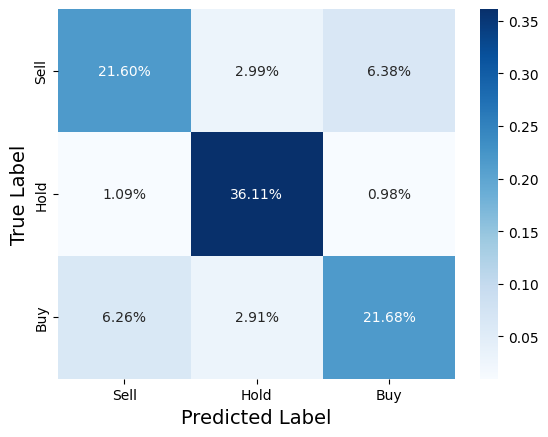

In [15]:
''' Plot confusion matrix '''
axlabels = ['Sell','Hold','Buy']
aylabels = ['Sell','Hold','Buy']
cf_matrix = confusion_matrix(y_test, classes, normalize='all')
s=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues',xticklabels=axlabels, yticklabels=aylabels)
s.set_xlabel('Predicted Label', fontsize=14)
s.set_ylabel('True Label', fontsize=14)


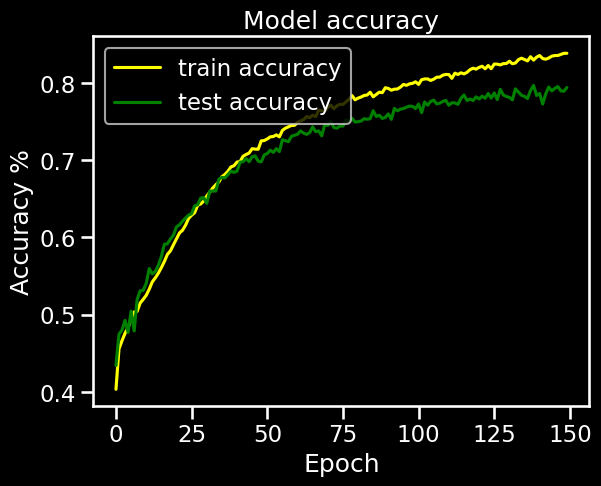

In [27]:
''' Plot train and test accuracy vs epoch chart '''
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

plt.plot(history.history['accuracy'], color="yellow")
plt.plot(history.history['val_accuracy'], color="green")
plt.title('Model accuracy')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'test accuracy'], loc='upper left')
plt.show()

In [13]:
def save_model(file_name):
    ''' Save the model as an h5 file'''
    model.save(file_name + ".h5", overwrite=True)
    # model.save( os.path.join(path, "model.h5") )
    print("Saved model to disk")

save_model('2000to2019_150epochs_model')

Saved model to disk


# K FOLD CROSS VALIDATION

In [ ]:
from sklearn.model_selection import KFold

input_train = X_train
input_test = X_test
target_train = y_train
target_test = y_test

# Model configuration
batch_size = 100
img_width, img_height, img_num_channels = IMAGE_HEIGHT, IMAGE_WIDTH, 1
loss_function = 'sparse_categorical_crossentropy'
no_classes = 3
no_epochs = 100
optimizer = 'Adam'
verbosity = 1
num_folds = 5

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Define per-fold score containers 
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((input_train, input_test), axis=0)
targets = np.concatenate((target_train, target_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  # Define the model architecture
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
  model.add(Dropout(0.20))
  model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.50))
  model.add(Dense(no_classes, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = (model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity))

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1



In [ ]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

print('------------------------------------------------------------------------')

In [16]:
Xs_outsample = np.load('Xs_outsample.npy',allow_pickle=True)
ys_outsample = np.load('ys_outsample.npy',allow_pickle=True)
print("Xs:",Xs_outsample.shape)
print("ys:",ys_outsample.shape)
print("Class label count:",sorted(Counter(ys_outsample).items()))

Xs: (22129, 50, 50)
ys: (22129,)
Class label count: [(0, 1761), (1, 18647), (2, 1721)]


In [17]:
Xs_a = Xs_outsample.reshape(-1,IMAGE_HEIGHT*IMAGE_WIDTH)
# ys_a = ys_outsample.reshape(-1,1)
print("Xs:",Xs_a.shape)
# print("ys:",ys_a.shape)

Xs: (22129, 2500)


In [18]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))


In [ ]:
import pickle
scalerfile = 'scaler.sav'
scaler = pickle.load(open(scalerfile, 'rb'))
# test_scaled_set = scaler.transform(test_set)

In [19]:
Xs_b = scaler.transform(Xs_a)
Xs_b

array([[0.89567767, 0.50294642, 0.39497492, ..., 0.09736971, 0.09748308,
        0.09734311],
       [0.89447368, 0.49815383, 0.4101446 , ..., 0.09659885, 0.09686795,
        0.09693691],
       [0.89922515, 0.51706757, 0.41618096, ..., 0.09627795, 0.096901  ,
        0.09699793],
       ...,
       [0.88540821, 0.46206774, 0.35420754, ..., 0.01135198, 0.01133276,
        0.01130495],
       [0.83367856, 0.25615219, 0.31433214, ..., 0.0087217 , 0.00898156,
        0.0090165 ],
       [0.80265569, 0.13266226, 0.26482745, ..., 0.00870393, 0.00875915,
        0.00877812]])

In [20]:
Xs_c = Xs_b.reshape(-1,IMAGE_HEIGHT,IMAGE_WIDTH,1)
y = ys_outsample.reshape(-1,1)
print("Xs:",Xs_c.shape)
print("ys:",ys.shape)

Xs: (22129, 50, 50, 1)
ys: (47302,)


In [21]:
y_pred = model.predict(Xs_c,verbose=1)
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels

692/692 [==============================] - 2s 3ms/step


array([0, 0, 2, ..., 1, 1, 1])

In [22]:
y_true = y.reshape(-1)
print("ys True Label:",y_true.shape)
print("ys Predicted Label:",y_pred_labels.shape)

ys True Label: (22129,)
ys Predicted Label: (22129,)


In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true,y_pred_labels)

0.4782864114962267

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_labels, target_names=['Sell','Hold','Buy'], digits=4))

              precision    recall  f1-score   support

        Sell     0.0858    0.3634    0.1389      1761
        Hold     0.8491    0.5183    0.6437     18647
         Buy     0.0848    0.1621    0.1113      1721

    accuracy                         0.4783     22129
   macro avg     0.3399    0.3480    0.2980     22129
weighted avg     0.7290    0.4783    0.5621     22129



Text(50.722222222222214, 0.5, 'True Label')

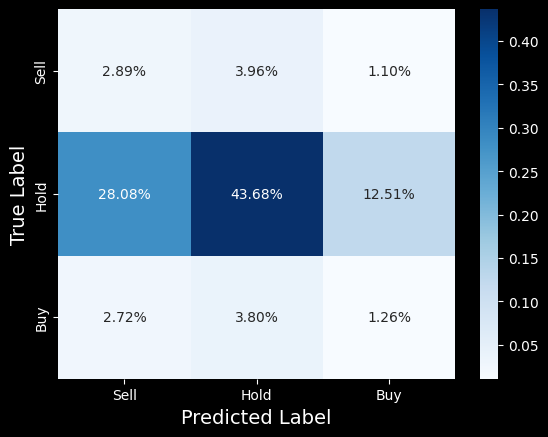

In [26]:
plt.style.use("dark_background")
''' Plot confusion matrix '''
axlabels = ['Sell','Hold','Buy']
aylabels = ['Sell','Hold','Buy']
cf_matrix = confusion_matrix(y_true, y_pred_labels, normalize='all') 
s=sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues',xticklabels=axlabels, yticklabels=aylabels)
s.set_xlabel('Predicted Label', fontsize=14)
s.set_ylabel('True Label', fontsize=14)
